# Bayesian Logistic Regression

In this example, we will use the `racecar` library to draw samples from a logistic regression posterior fitting parameters to a dataset.

We will compare the results for sampling the posterior for a number of available algorithms.

First, we import our packages and load the dataset.

In [1]:
# Import our packages
import racecar as rc
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.ndimage.filters import uniform_filter1d

print('This example was run with Racecar Version %s' % rc.__version__)

# Set the Seaborn defaults
sns.set()

# Set a seed for reproducibility
np.random.seed(271828)

This example was run with Racecar Version 0.0.9


We will use the `German Credit Dataset` widely used as a benchmark for these problems. We have 25 parameters to fit, and there are 1000 datapoints in this dataset.

The racecar package has a BLR posterior built-in, including a mild Gaussian prior. We only need provide it the data and optionally a list of data indexes to use. If we only use a portion of the data, the function will automatically scale the result to ensure the gradient is of the correct size.

A faster choice for computing the gradient is to only use a random subset of datapoints every iteration. We can create a cheaper version of the iteration by only using _5%_ of the data instead.

In [2]:
blr_data = np.load('../data/german.npz')
data = blr_data['data']
t = blr_data['t']
initial_condition = blr_data['ic']
Ndata = data.shape[1]
Nbatch = Ndata //20

print('German Credit dataset. Dimensionality: %s, Number of datapoints: %s' % data.shape )

def llh_full(x):
    
    return rc.llh.blr(x, data, t)

def llh_cheap(x):
    
    idxs = np.random.choice( Ndata , Nbatch, replace=False)
    
    return rc.llh.blr(x, data, t, idxs)


German Credit dataset. Dimensionality: 25, Number of datapoints: 1000


In a low-level language like _C_ or _FORTRAN_ we would expect this to give us around a _20x_ speed up in each evaluation. In Python, thanks to Numpy's vectorization we do not get a speed up quite that large:

In [3]:
result = llh_full(initial_condition)

print('Using all datapoints:')
%timeit  llh_full(initial_condition)
print('\nUsing 5% of data:')
%timeit  llh_cheap(initial_condition)

Using all datapoints:
572 µs ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Using 5% of data:
267 µs ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We would need a larger dataset to truly reflect the linear scaling in time, but for our proof-of-concept these time savings will be sufficient.

We will use the full gradient to compare our results against. As we are in a modest dimension with a non-linear posterior, we can use the HMC scheme to give us a non-biased benchmark result.

In [4]:
S = rc.sampler(initial_condition, 0.05, llh_full, algo='hmc',params={'M':1})
S.sample(1000, output=[])
Q_hmc = S.sample(50000, output=['pos'])

We will compare the results of using four algorithms:

- Racecar
- BADODAB
- SGHMC
- SGLD

with the cheaper gradient using 5% of the data. The Racecar and BADODAB algorithms require minimal setup, but the SGHMC algorithm requires an estimate of the gradient covariance. The `rc.llh.blr` function outputs `grad_data`, which is each of the gradient pieces over the data. We can use the covariance of this as the covariance of the stochastic gradient. We compare the result below:

In [5]:
# Calculated as the covariance of a partial sum
def SGHMC_noise_estimate(B,grad_data): 
    
    Bfac = (Ndata * (Ndata - Nbatch) / Nbatch)
    new_B = np.cov( grad_data ) * Bfac
    
    return new_B

# Compare the truth versus the estimated:
#
# Compute the covariance of 1000 stochastic gradient evals
grad_covariance = np.cov( np.hstack([llh_cheap(initial_condition)['grad'] for repeat in range(10000)] )) 

# Compute the mean of 1000 noise estimates. Note that grad_data is itself a stochastic estimation!
estimated_grad_covariance = [SGHMC_noise_estimate( B=None, grad_data=llh_cheap(initial_condition)['grad_data'] ) 
                                                                  for repeat in range(10000)]

print('True (3x3 portion) covariance matrix of the stochastic grad:')
print( grad_covariance[:3,:3]  )
print('\nMean (3x3 portion) of the "SGHMC noise estimate" function:')
print( np.array( estimated_grad_covariance).mean(0)[:3,:3] )


True (3x3 portion) covariance matrix of the stochastic grad:
[[2923.46165455 -987.92642695  353.24978694]
 [-987.92642695 2832.74655894 -138.67769724]
 [ 353.24978694 -138.67769724 2934.17622342]]

Mean (3x3 portion) of the "SGHMC noise estimate" function:
[[ 2975.78949812 -1003.76042722   348.61949485]
 [-1003.76042722  2813.58123935  -110.37054367]
 [  348.61949485  -110.37054367  2932.34892734]]


You should see good agreement above. This is an inexpensive approximation to the covariance at any point $x$.

We can run each of the algorithms and store the resulting trajectory. To get good statistics, we will run for 250,000 steps.

_Note: You may wish to run for a shorter time if you're running this yourself!_

In [6]:
# Number of steps to run
Nsteps = 250000

# The four algorithms
algos = ['racecar','badodab','sghmc','sgld']

# The discretization steps for each algorithm
hvals = [0.02,0.02,0.005,0.001]

# Special parameters 
params = [ {}, 
         {}, 
         {"grad_cov":SGHMC_noise_estimate},
         {},
         ]

# The list of result trajectories
results = [] 

# Iterate over the algorithms and store the result trajectory
for ii, (a,h,p) in enumerate(zip(algos, hvals,params)):
    
    # Create the Sampler object, using the cheap posterior function
    S = rc.sampler(initial_condition, h, llh_cheap, algo=a, params=p)
    
    # Sample some initial steps to decorrelate from the initial condition
    S.sample(10000, output=[])
    
    # Sample a longer trajectory to generate statistics 
    # If memory is an issue, run with a higher ``thin`` value
    Q = S.sample(Nsteps, output=['pos'], thin=1) 
    
    # Add these results to the list for analysis later
    results.append(Q)

Once we have the trajectories, we can look at the mean squared error (MSE) as a function of the number of iterations. For these methods, we are interested in two metrics:

- The speed at which the schemes converge to their result
- The bias which the method's inflict upon the final value

The controlling factor is normally the discretization step `h`; a smaller `h` means a slower convergence speed but a reduction in the bias. It is a tradeoff between getting a more accurate result, but slower.

We will compute the MSE in the computed averages of $\|x\|^2$ as a function of time (actually _iterations_) on a log scale. The left plot shows the method's convergence towards its biased value, and the right plot shows its convergence towards the true value (computed earlier with the bias-free scheme HMC).

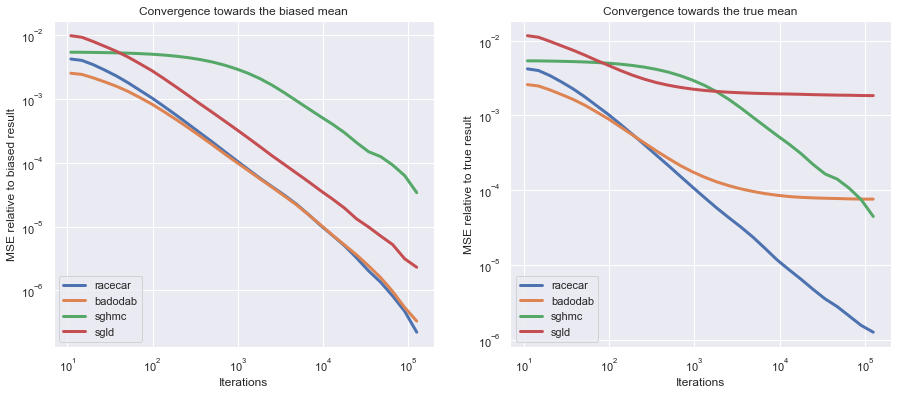

In [7]:
# Create the Figure object
fig = plt.figure(figsize=[15,6])
ax_l = fig.add_subplot(1,2,1)
ax_r = fig.add_subplot(1,2,2)

# Loop through the data we collected
for a,Q in zip(algos,results):
    # Compute the average over different sized windows
    sizes = np.geomspace(5,Q.shape[0]//4,30)
    
    # We will look at the error in x^2
    # Compute the difference between its computed mean here 
    QQ = (Q**2) - (Q**2).mean(0)
    # And the difference between the "true" mean here
    QQ2 = (Q**2) - (Q_hmc**2).mean(0)
    # Store the results in these lists 
    yy = []
    zz = [] 
    
    # Loop over each size window 
    for s in sizes:
        ss = int(s)
        sz = 1 + 2*ss
        
        # This will take an average of points over an iteration window of size "sz"
        U  = uniform_filter1d( QQ ,axis=0,size=sz,mode='constant')[ss:-ss,:]
        V  = uniform_filter1d( QQ2 ,axis=0,size=sz,mode='constant')[ss:-ss,:]
        
        # Add the MSE 
        yy.append( (U**2).mean() )
        zz.append( (V**2).mean() ) 
        
    # Plot the results
    ax_l.loglog(1+2*sizes,yy,linewidth=3,label=a)
    ax_r.loglog(1+2*sizes,zz,linewidth=3,label=a)
    
ax_l.legend(loc=3)
ax_l.set_title('Convergence towards the biased mean')
ax_l.set_ylabel('MSE relative to biased result')
ax_l.set_xlabel('Iterations')
ax_r.legend(loc=3)
ax_r.set_title('Convergence towards the true mean')
ax_r.set_ylabel('MSE relative to true result')
ax_r.set_xlabel('Iterations')
plt.show()

### Results

The results here are all produced from one long trajectory, and as such are subject to the usual experimental error. This is particularly noticable at the ends of the curves where we have very few samples, leading to some strange wiggles and kinks due to noise. The user is free to run repeat results to smooth it out, but the main takeaways should still be apparent from one run.

##### Speed of convergence

From the left plot, we can see that the error falls fastest for the BADODAB and Racecar schemes. The SGLD scheme is 3-4x slower, and the SGHMC is around 40x slower. The SGLD scheme discretizes a first-order dynamics and se we would not expect its step size to be easily comparable to the other schemes, however SGHMC is a discretization of a similar Langevin dynamics to Racecar, and it seems strange that a timestep of 4x smaller would produce such a huge speed difference.

The key point here is that SGHMC requires a significantly larger damping constant than the other schemes, that ends up stifling its exploration and hobbling its convergence rate. Increasing its timestep further requires an even larger damping that can drive the system to instability.

##### Introduced bias

The right plot shows the error compared to the bias-free result from HMC. We can see that the SGLD scheme gives the largest error, while BADODAB improves on SGLD by an order of magnitude (as well as converging faster). The bias of the SGHMC scheme is not resolvable in the sampling, owing to the slow convergence of the scheme. However it is clear that the Racecar scheme performs considerably better than the others, even without the heuristic approximation of the stochastic gradient's covariance used by SGHMC.